In [1]:
# Compute the DMM and PA statistics for a specified region in the Med.
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import xarray as xr
import pandas as pd
import glob
import geometry as gm # grad_sphere, div_sphere, nan_gaussian_filter
import distributions as dstr

In [2]:
crs = ccrs.PlateCarree()
def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [3]:
# Open file.
exp = 'CPL' # 'CPL', 'ATM', 'SMT'
ds = xr.open_dataset('one_day_wrfout_'+exp+'.nc')

In [4]:
# Set the standard deviation of the Gaussian filter to be used to evaluate the background wind.
sigma = 50 # 250 km.

In [6]:
# Select here the fields to be analysed.
mech = 'DMM' # 'DMM', 'PA'
if mech=='DMM':
    str_a = 'dsst_dr' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
    str_b = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
    alpha_units = 'm s$^{-1}$ K$^{-1}$' # 'm s$^{-1}$ K$^{-1}$' or 'm$^2$ s$^{-1}$ K$^{-1}$'
elif mech=='PA':
    str_a = 'd2sst_ds2' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
    str_b = 'ds_dot_prime_ds' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
    alpha_units = 'm$^2$ s$^{-1}$ K$^{-1}$' # 'm s$^{-1}$ K$^{-1}$' or 'm$^2$ s$^{-1}$ K$^{-1}$'
    
plot_wind_sst = True
plot_maps = True

extent_zoom = [20,40,30,40]

In [8]:
# Loop on time.

a = []
b = []

for tt in range(len(ds.Time)):
    u10 = ds.U10[tt].values
    v10 = ds.V10[tt].values
    sst = ds.SST[tt].values
    if tt == 0:
        seamask = sst/sst
        lon = ds.XLONG[0].values
        lat = ds.XLAT[0].values
        extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)]
        a_timeavg = np.zeros_like(lon)
        b_timeavg = np.zeros_like(lon)
        
    wspd = np.sqrt(u10**2+v10**2)

    # Get the background wind field.
    smooth_u = gm.nan_gaussian_filter(u10*seamask,sigma)
    smooth_v = gm.nan_gaussian_filter(v10*seamask,sigma)
    smooth_ws = np.sqrt(smooth_u**2+smooth_v**2)
    
    cosphi = smooth_u/smooth_ws
    sinphi = smooth_v/smooth_ws

    # Get the anomalies with respect to the background wind field.
    u_prime = u10-smooth_u
    v_prime = v10-smooth_v
    
    dsst_dx, dsst_dy = gm.grad_sphere(sst*seamask,lon,lat)
    if str_a=='gamma':
        a_prime = u10*dsst_dx + v10*dsst_dy
        x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
    elif str_a=='dsst_dr':
        a_prime = dsst_dx*cosphi + dsst_dy*sinphi
        x_string = 'dSST/dr [K/m]'; vmin_a=-5e-5; vmax_a=5e-5
    elif str_a=='lapl_sst':
        a_prime = gm.div_sphere(dsst_dx,dsst_dy,lon,lat)
        x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
    elif str_a=='d2sst_ds2':
        dsst_ds = -dsst_dx*sinphi + dsst_dy*cosphi
        ddsst_ds_dx, ddsst_ds_dy = gm.grad_sphere(dsst_ds,lon,lat)
        a_prime = -ddsst_ds_dx*sinphi + ddsst_ds_dy*cosphi
        x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-5e-9; vmax_a=5e-9

    if str_b=='wind_div':
        b_prime = gm.div_sphere(u10,v10,lon,lat)
        y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
    elif str_b=='dr_dot_prime_dr':
        r_dot_prime = u_prime*cosphi + v_prime*sinphi
        dr_dot_prime_dx, dr_dot_prime_dy = gm.grad_sphere(r_dot_prime,lon,lat)
        b_prime = dr_dot_prime_dx*cosphi + dr_dot_prime_dy*sinphi 
        y_string = 'dr dot prime/dr [1/s]'; vmin_b=-1e-4; vmax_b=1e-4#vmin_b=-2.2e-4; vmax_b=2.2e-4
    elif str_b=='ds_dot_prime_ds':
        s_dot_prime = -u_prime*sinphi + v_prime*cosphi
        ds_dot_prime_dx, ds_dot_prime_dy = gm.grad_sphere(s_dot_prime,lon,lat)
        b_prime = -ds_dot_prime_dx*sinphi + ds_dot_prime_dy*cosphi
        y_string = 'ds dot prime/ds [1/s]'; vmin_b=-1e-4; vmax_b=1e-4#vmin_b=-2.2e-5; vmax_b=2.2e-5

    if plot_wind_sst:
        # Plot wind speed and SST.
        from matplotlib import cm
        plasma20 = cm.get_cmap('plasma', 20)
        viridis10 = cm.get_cmap('viridis', 10)

        fig = plt.figure(figsize=(14,10))

        ax0 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax0)
        pc0 = ax0.pcolormesh(lon,lat,wspd,vmin=0,vmax=20,shading='nearest',
                           transform=ccrs.PlateCarree(),cmap=plasma20)
        step = 50
        ax0.barbs(lon[::step,::step],lat[::step,::step],u10[::step,::step],v10[::step,::step],length=6)
        cbar0 = plt.colorbar(pc0)
        cbar0.ax.tick_params(labelsize=12) 
        cbar0.set_label('Wind speed [m/s]',size=14)
        ax0.set_extent(extent)

        ax1 = fig.add_subplot(2, 1, 2, projection=crs)
        plot_background(ax1)
        #ax1.contour(lon,lat,(sst-273.15)*sstmask,levels=np.arange(0,30),colors='w',transform=ccrs.PlateCarree())
        pc1 = ax1.pcolormesh(lon,lat,(sst-273.15)*seamask,vmin=10,vmax=20,shading='nearest',
                             transform=ccrs.PlateCarree(),cmap=viridis10)
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        cbar1.set_label('SST [°C]',size=14)
        ax1.set_extent(extent)

        figure_name = 'wind_sst_map_' + "{:02}".format(tt) + '_'+exp+ '.png'
        plt.savefig('./figures/'+figure_name,bbox_inches='tight')
   
    if plot_maps:
        # Plot the two fields.
        fig = plt.figure(figsize=(14,10))

        ax0 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax0)
        pc0 = ax0.pcolormesh(lon,lat,a_prime,vmin=vmin_a,vmax=vmax_a,shading='nearest',
                           transform=ccrs.PlateCarree(),cmap='seismic')
        step = 50
        ax0.barbs(lon[::step,::step],lat[::step,::step],u10[::step,::step],v10[::step,::step],length=6)
        cbar0 = plt.colorbar(pc0)
        cbar0.ax.tick_params(labelsize=12) 
        cbar0.set_label(x_string,size=14)
        ax0.set_extent(extent_zoom)

        ax1 = fig.add_subplot(2, 1, 2, projection=crs)
        plot_background(ax1)
        #ax1.contour(lon,lat,(sst-273.15)*sstmask,levels=np.arange(0,30),colors='w',transform=ccrs.PlateCarree())
        pc1 = ax1.pcolormesh(lon,lat,b_prime,vmin=vmin_b,vmax=vmax_b,shading='nearest',
                             transform=ccrs.PlateCarree(),cmap='seismic')
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        cbar1.set_label(y_string,size=14)
        ax1.set_extent(extent_zoom)

        figure_name = str_a+'_'+str_b+'_' + "{:02}".format(tt) + '_'+exp+ '.png'
        plt.savefig('./figures/'+figure_name,bbox_inches='tight')

    # Save to compute the time averaged fields.
    a_timeavg += a_prime
    b_timeavg += b_prime
    
    # Crop over the area of interest.
    a_sub = gm.crop_field(a_prime,lon,lat,extent_zoom)
    b_sub = gm.crop_field(b_prime,lon,lat,extent_zoom)
    
    # Concatenate the variables of interest.
    a_to_be_concat = a_sub[(~np.isnan(a_sub))&(~np.isnan(b_sub))]
    b_to_be_concat = b_sub[(~np.isnan(a_sub))&(~np.isnan(b_sub))]

    a = np.concatenate((a,a_to_be_concat))
    b = np.concatenate((b,b_to_be_concat))
    
nvalues = len(ds.Time)+1
a_timeavg = a_timeavg/nvalues
b_timeavg = b_timeavg/nvalues

<ipython-input-8-c01a53104e48>:11: RuntimeWarning: invalid value encountered in true_divide
  seamask = sst/sst
/home/agostino/air-sea_med_wrf/geometry.py:77: RuntimeWarning: divide by zero encountered in true_divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
<ipython-input-8-c01a53104e48>:25: RuntimeWarning: invalid value encountered in true_divide
  cosphi = smooth_u/smooth_ws
<ipython-input-8-c01a53104e48>:26: RuntimeWarning: invalid value encountered in true_divide
  sinphi = smooth_v/smooth_ws


FileNotFoundError: [Errno 2] No such file or directory: './figures/scatter_plot_dsst_dr_dr_dot_prime_dr.png'

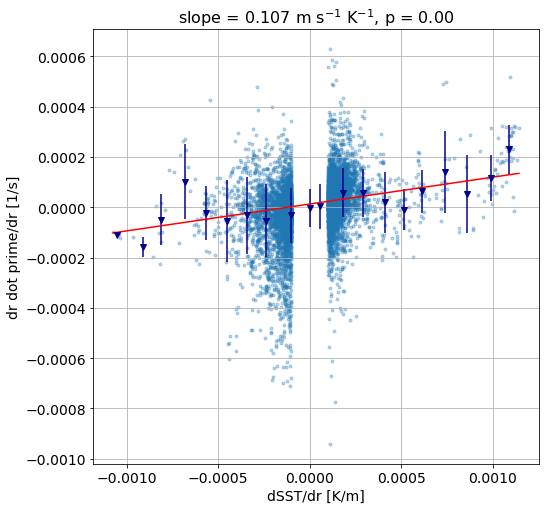

In [9]:
# Plot the distributions.
perc_step = 5
str_title = 'one day' 
str_name = 'one_day_wrfout_sigma' + str(sigma)

# Set the xlim and ylim for the mixed distribution figure.
xlimiti=np.nan; ylimiti=np.nan

a[np.isinf(a)] = np.nan
b[np.isinf(b)] = np.nan
#dstr.mixed_distribution_with_hist(a,b,str_a,str_b,xlimiti,ylimiti,x_string,y_string,perc_step,title=str_title,str_name=str_name)

plt.figure(figsize=(8,8))
plt.scatter(a[(a>1e-4)|(a<-1e-4)],b[(a>1e-4)|(a<-1e-4)],alpha=0.3,marker='.') # DMM
#plt.scatter(a[(a>1e-8)|(a<-1e-8)],b[(a>1e-8)|(a<-1e-8)],alpha=0.3,marker='.') # PA
#plt.scatter(a.flatten(),b.flatten(),alpha=0.3,marker='.')
slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope = dstr.metrics_fixed_bin_distribution(a,b,perc_step)
ics = np.array([np.min(a),np.max(a)])
ipsilon = slope*ics + intercept
plt.plot(ics, ipsilon, 'r')
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb,fmt='v',color='darkblue')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope), fontsize=16)

figure_name = 'scatter_plot_' + str_a + '_' + str_b + '_'+exp+ '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')